#Part 1: Introduction to Research Environment

In [1]:
from quantopian.interactive.data.sentdex import sentiment

Above, we're bringing in the Sentdex sentiment dataset. The sentiment dataset provides sentiment data for companies from ~June 2013 onward for about 500 companies, and is free to use on Quantopian up to a rolling 1 month ago.
The Sentdex data provides a signal ranging from -3 to positive 6, where positive 6 is equally as positive as -3 is negative, I just personally found it more necessary to have granularity on the positive side of the scale.

We will also import the Q1500, which is Quantopian's sort of "index" that tracks 1500 of the most liquid companies that make the most sense for trading. The idea here is that, in order to properly back-test, you're assuming your shares will actually move at a fair pace. They might take a minute to fill, but we're not expecting them to take days. The Q1500 is a nightly updated list of acceptable companies that we can rely on to be liquid.

In [2]:
from quantopian.pipeline.filters.morningstar import Q1500US

In [3]:
type(sentiment)

<class 'blaze.expr.expressions.Field'>

Note that the datasets you import in the Research section are Blaze expressions. More info: https://blaze.readthedocs.io/en/latest/

We can see the attributes:

In [4]:
dir(sentiment)

['apply',
 u'asof_date',
 'cast',
 'count',
 'count_values',
 'distinct',
 'dshape',
 'fields',
 'head',
 'isidentical',
 'map',
 'ndim',
 'nelements',
 'nrows',
 'nunique',
 'peek',
 'relabel',
 'sample',
 'schema',
 u'sentiment_signal',
 'shape',
 'shift',
 u'sid',
 'sort',
 u'symbol',
 'tail',
 u'timestamp']

Blaze abstracts out computation and storage, aiming to give you faster speeds. From what I've seen blaze is about 4-6x faster than your typical pandas dataframe. Considering the sizes of the dataframes we're using here and the compute times, this is a great improvement, we'll take it.
As far as we're concerned, however, we're mostly going to just treat this like a pandas dataframe. For example:

In [5]:
BAC = symbols('BAC').sid
bac_sentiment = sentiment[ (sentiment.sid==BAC) ]
bac_sentiment.head()

symbol  sentiment_signal    sid  asof_date  timestamp
0    BAC               6.0  700.0 2012-11-14 2012-11-15
1    BAC               1.0  700.0 2012-11-15 2012-11-16
2    BAC              -1.0  700.0 2012-11-16 2012-11-17
3    BAC              -1.0  700.0 2012-11-17 2012-11-18
4    BAC              -1.0  700.0 2012-11-18 2012-11-19
5    BAC               6.0  700.0 2012-11-19 2012-11-20
6    BAC               6.0  700.0 2012-11-20 2012-11-21
7    BAC               6.0  700.0 2012-11-21 2012-11-22
8    BAC               6.0  700.0 2012-11-22 2012-11-23
9    BAC               6.0  700.0 2012-11-23 2012-11-24

While .head() is going to still work, .peek() is blaze, and quicker

In [6]:
bac_sentiment.peek()

symbol  sentiment_signal    sid  asof_date  timestamp
0     BAC               6.0  700.0 2012-11-14 2012-11-15
1     BAC               1.0  700.0 2012-11-15 2012-11-16
2     BAC              -1.0  700.0 2012-11-16 2012-11-17
3     BAC              -1.0  700.0 2012-11-17 2012-11-18
4     BAC              -1.0  700.0 2012-11-18 2012-11-19
5     BAC               6.0  700.0 2012-11-19 2012-11-20
6     BAC               6.0  700.0 2012-11-20 2012-11-21
7     BAC               6.0  700.0 2012-11-21 2012-11-22
8     BAC               6.0  700.0 2012-11-22 2012-11-23
9     BAC               6.0  700.0 2012-11-23 2012-11-24
10    BAC               6.0  700.0 2012-11-24 2012-11-25

In most cases, you're going to just run some computations in the form of filters and factors, but, if you did want to do some pandas-specific things on this data, you would first need to convert it back to a dataframe. For example, if you wanted to utilize the .plot attribute that a dataframe has, you would need to do this:

In [7]:
import blaze

bac_sentiment = blaze.compute(bac_sentiment)
type(bac_sentiment)

<class 'pandas.core.frame.DataFrame'>

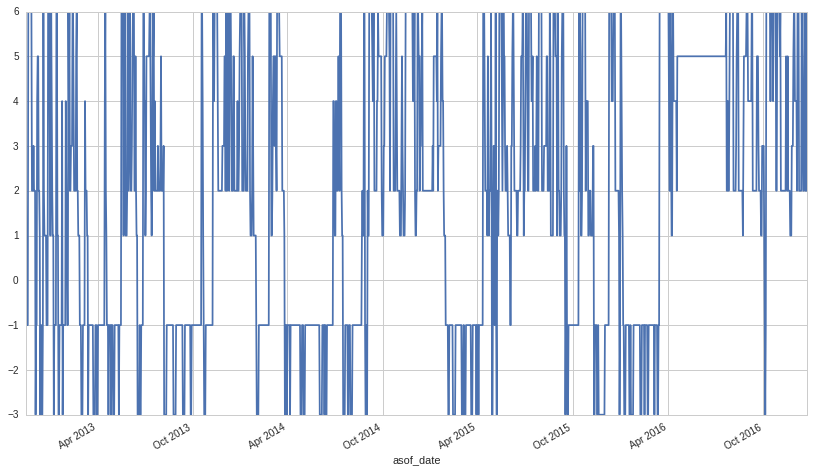

In [8]:
bac_sentiment.set_index('asof_date', inplace=True)
bac_sentiment['sentiment_signal'].plot()

The sentiment signals are generated by moving average crossovers generated straight from raw sentiment. Initially, those moving averages are going to be quite wild, so you wouldn't want to use the earliest data. For example:

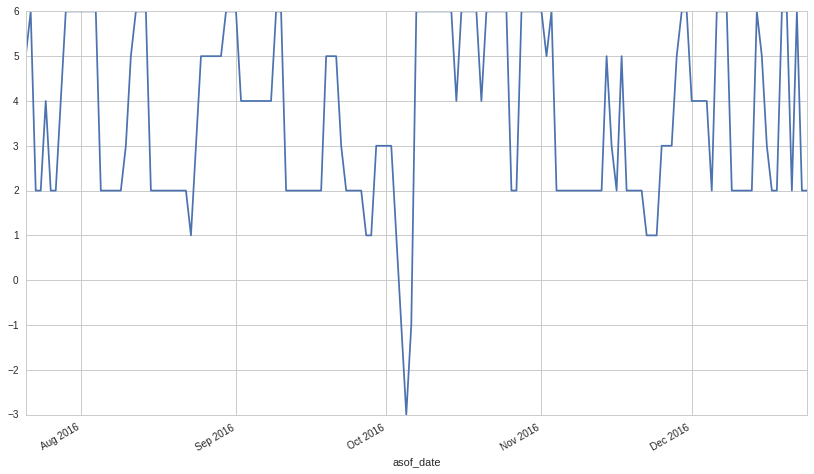

In [9]:
bac_sentiment = bac_sentiment[ (bac_sentiment.index > '2016-06-01') ]
bac_sentiment['sentiment_signal'].plot()

#Part 2: Pipeline Basics#

The idea behind the pipeline is to allow you to quickly and efficiently consider many thousands of companies (~8,000 total on Quantopian).

The challenge that Pipeline overcomes for you is that, in a typical strategy, you might want to compute a function, or maybe check for some fundamental factor, but you want to do this against all companies, not just some arbitrarily limited group of companies. Pipeline allows you to address all companies, then filter them.

We will start with a simple example:

In [1]:
from quantopian.pipeline import Pipeline

def make_pipeline():
    return Pipeline()

A pipeline object is created with our make_pipeline() function, but currently we're doing nothing here, so we've not yet filtered any companies, and this pipeline will have every company inside of it.

To actually run a pipeline, we need to import run_pipeline. It's important to note that this is different in the research environment than in an algorithm, as a few of your imports will be. To bring in the run_pipeline function for research:

In [2]:
from quantopian.research import run_pipeline

my_pipe = make_pipeline()
result = run_pipeline(my_pipe, start_date='2015-05-05', end_date='2015-05-05')

In this case, our result is just for a single day. The more days you consider, the longer this process will take, so, while we're just learning, we'll keep it short. Result is a Pandas dataframe, so we can do all sorts of actions against it. For now, it's actually a pretty boring one:

In [3]:
result.head()

Empty DataFrame
Columns: []
Index: [(2015-05-05 00:00:00+00:00, Equity(2 [ARNC])), (2015-05-05 00:00:00+00:00, Equity(21 [AAME])), (2015-05-05 00:00:00+00:00, Equity(24 [AAPL])), (2015-05-05 00:00:00+00:00, Equity(25 [ARNC_PR])), (2015-05-05 00:00:00+00:00, Equity(31 [ABAX]))]

In [4]:
len(result)

8240

We can also see that we've not reduced our universe of companies of interest at all! Let's modify our pipeline function to fix this!

In [6]:
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.filters.morningstar import Q1500US
from quantopian.pipeline.data.sentdex import sentiment

def make_pipeline():
    
    #Factor returns 
    sentiment_factor = sentiment.sentiment_signal.latest
    
    # Our universe is made up of stocks that have a non-null sentiment signal that was updated in
    # the last day, are not within 2 days of an earnings announcement, are not announced acquisition
    # targets, and are in the Q1500US.
    universe = (Q1500US() 
                & sentiment_factor.notnull())
    
    # A classifier to separate the stocks into quantiles based on sentiment rank.

    
    # Go short the stocks in the 0th quantile, and long the stocks in the 2nd quantile.
    pipe = Pipeline(
        columns={
            'sentiment': sentiment_factor,
            'longs': (sentiment_factor >=4),
            'shorts': (sentiment_factor<=2),
        },
        screen=universe
    )
    
    return pipe

In [7]:
result = run_pipeline(make_pipeline(), start_date='2015-01-01', end_date='2016-01-01')

In [8]:
result.head()

longs  sentiment shorts
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])   False        2.0   True
                          Equity(24 [AAPL])  False        2.0   True
                          Equity(62 [ABT])   False        1.0   True
                          Equity(67 [ADSK])   True        6.0  False
                          Equity(76 [TAP])   False       -3.0   True